# Sign Language Recognition - Data Preprocessing

This notebook details the steps involved in preparing the dataset for training the sign language recognition model. The preprocessing includes loading the dataset, detecting hands using MediaPipe, and preparing the data for model training.


In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt

print("Libraries imported successfully.")

Libraries imported successfully.


### Define the paths to the dataset containing sign language images for each alphabet.

In [2]:
DATA_PATH = 'datasets/asl/'
LABELS = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'

# Initialize an empty list to store the file paths and their corresponding labels
data = []

### Create a CSV file containing image filenames and their corresponding labels for easier data management.

In [3]:
for label in LABELS:
    folder_path = os.path.join(DATA_PATH, label)
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        data.append([image_name, label])

# Save annotations to CSV
df = pd.DataFrame(data, columns=['filename', 'label'])
df.to_csv('annotations.csv', index=False)
print("Annotations CSV created.")

Annotations CSV created.


### Load the annotations from the CSV and preview the dataset.

In [4]:
annotations_df = pd.read_csv('annotations.csv')
print(annotations_df.head())

              filename label
0   0_27_rotate_7.jpeg     0
1   0_32_rotate_9.jpeg     0
2  0_23_rotate_12.jpeg     0
3   0_55_rotate_5.jpeg     0
4   0_28_rotate_3.jpeg     0


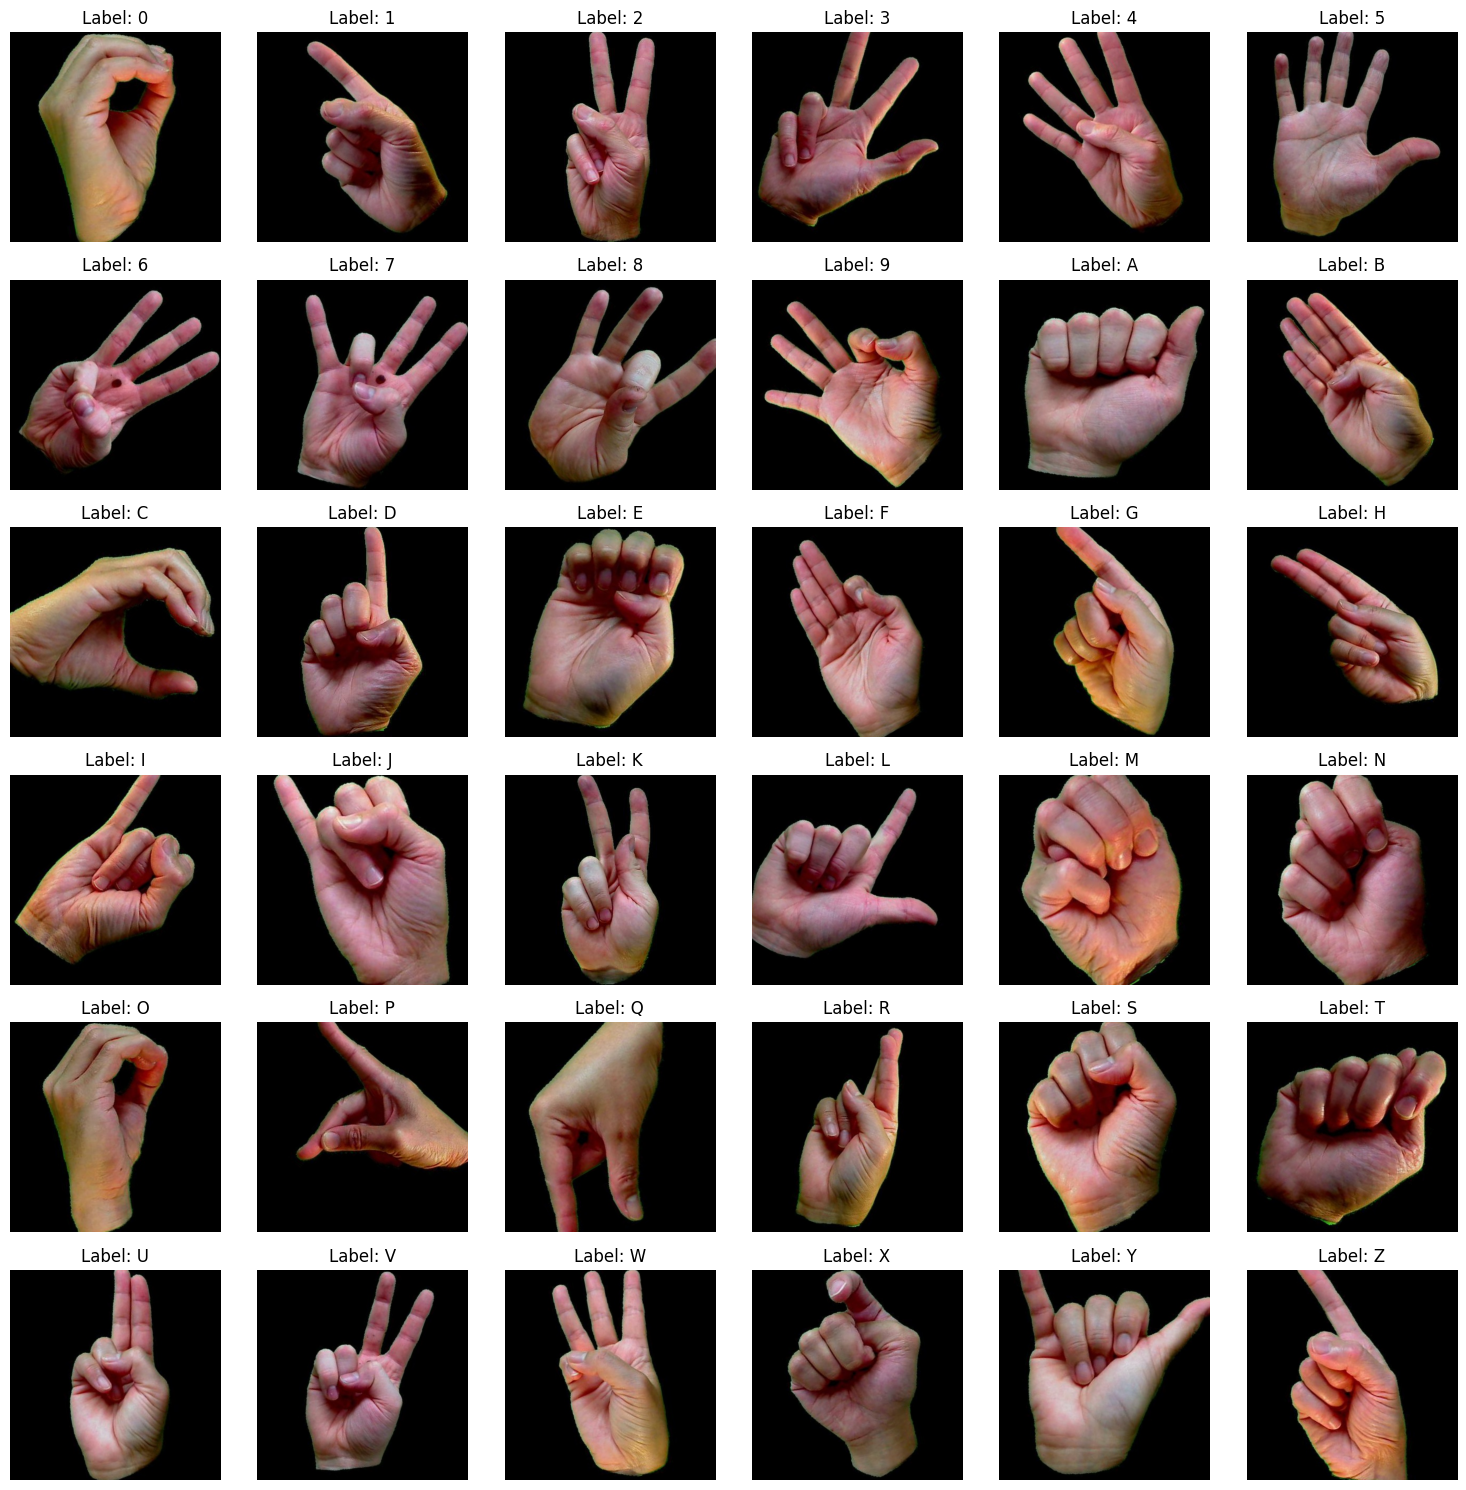

In [5]:
import os
import cv2
import matplotlib.pyplot as plt

# Préparer les données
sample_images = []
for label in LABELS:
    folder_path = os.path.join(DATA_PATH, label)
    if os.path.exists(folder_path):
        image_name = os.listdir(folder_path)[0]  # Prendre la première image du dossier
        img_path = os.path.join(folder_path, image_name)
        sample_images.append((img_path, label))

# Affichage des images
fig, axes = plt.subplots(6, 6, figsize=(15, 15))
axes = axes.ravel()

for i, (img_path, label) in enumerate(sample_images):
    img = cv2.imread(img_path)  # Charger l'image originale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir en RGB pour Matplotlib
    
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

# Supprimer les axes inutilisés si le nombre d'images est inférieur à 36
for i in range(len(sample_images), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


### Display some random images along with their labels to visualize the dataset.

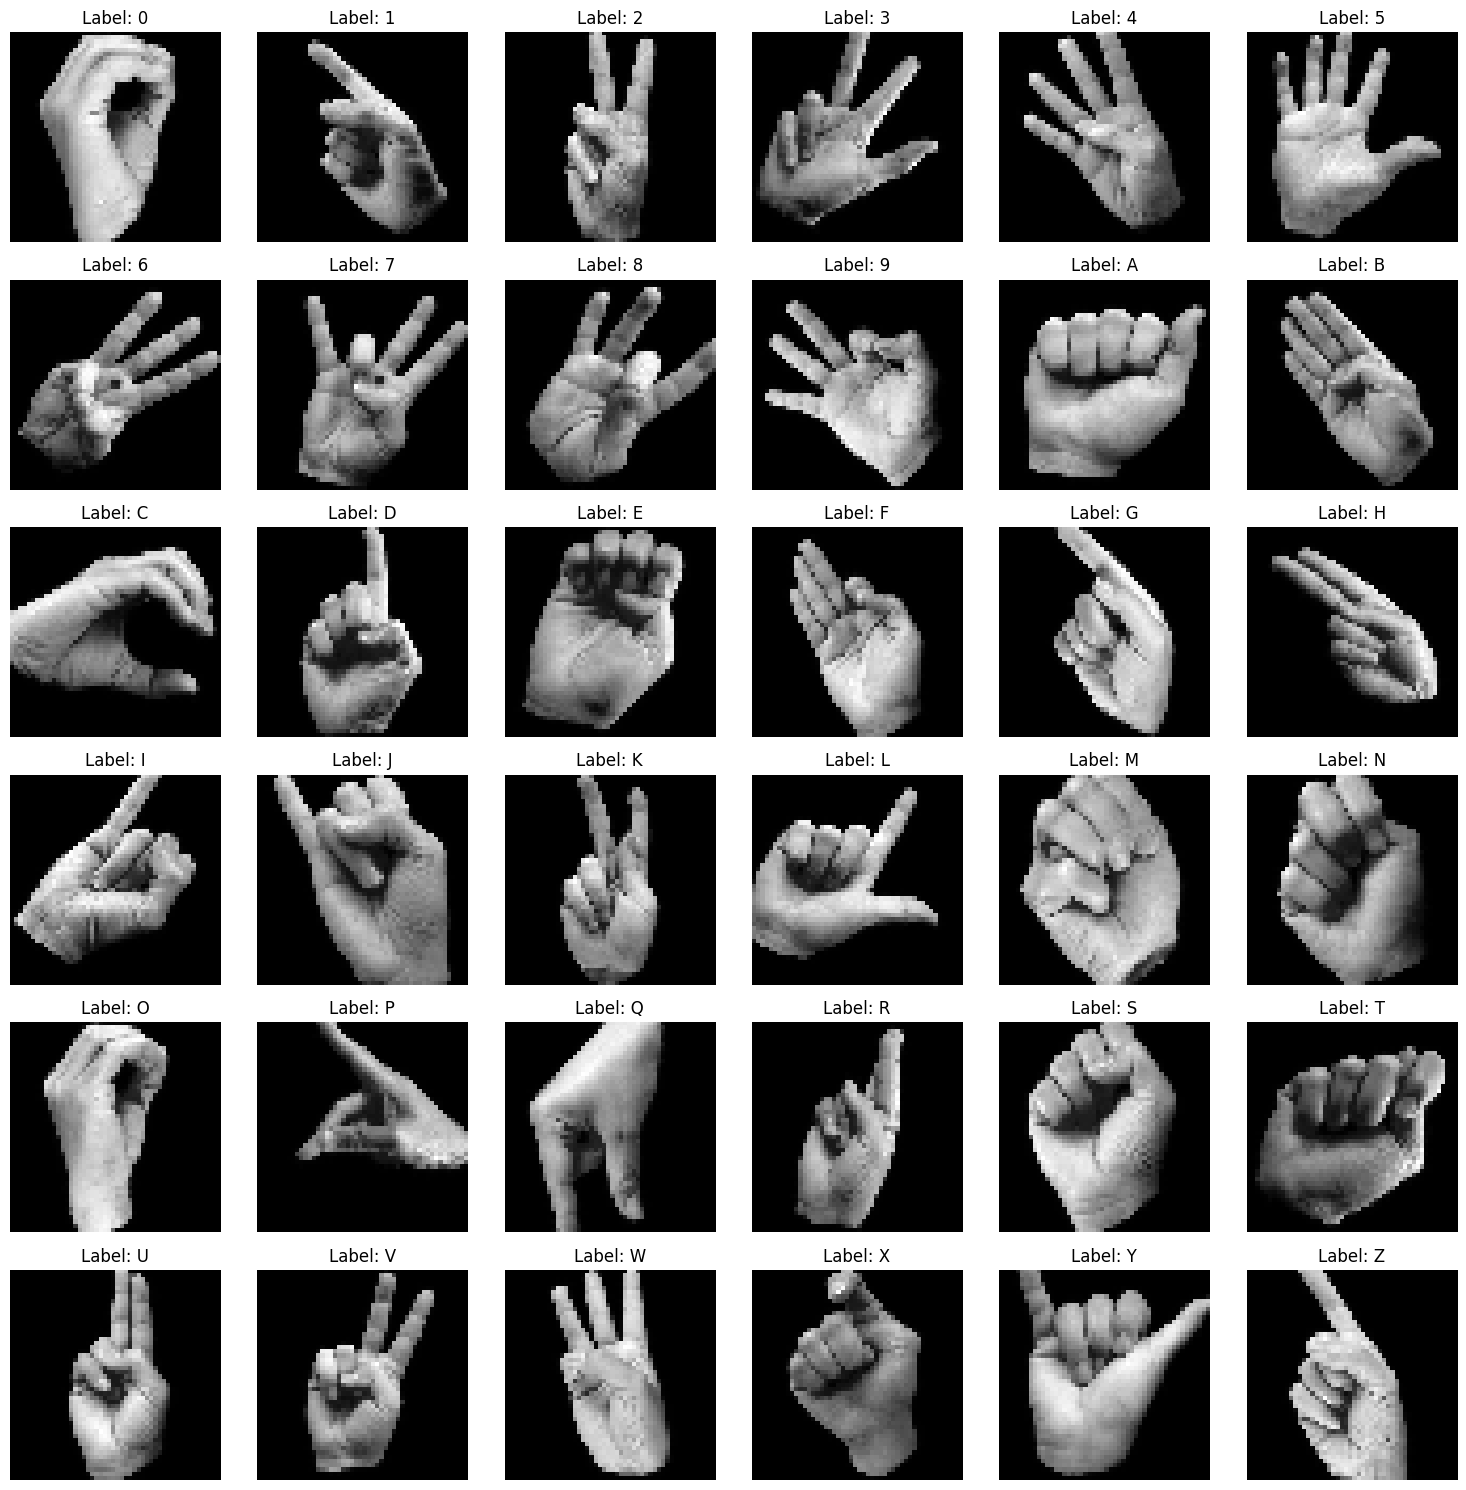

In [6]:
fig, axes = plt.subplots(6, 6, figsize=(15, 15))  # Grille 6x6 pour 36 images
axes = axes.ravel()

# Parcourir chaque label
for i, label in enumerate(LABELS):
    # Filtrer les lignes correspondant au label actuel
    label_df = annotations_df[annotations_df['label'] == label]
    
    # Vérifier si des images existent pour ce label
    if not label_df.empty:
        # Obtenir le chemin de la première image pour ce label
        img_path = os.path.join(DATA_PATH, label, label_df.iloc[0]['filename'])
        img = cv2.imread(img_path)  # Charger l'image d'origine
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convertir en niveaux de gris
        img = cv2.resize(img, (50, 50))  # Redimensionner à 50x50

        # Afficher l'image
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

# Supprimer les axes inutilisés s'il y en a
for i in range(len(LABELS), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


### Use MediaPipe to detect hands in the images and preprocess the images for model training.

In [8]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

def detect_hands(image):
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(img_rgb)
    
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            for landmark in hand_landmarks.landmark:
                h, w, _ = image.shape
                cx, cy = int(landmark.x * w), int(landmark.y * h)
                cv2.circle(image, (cx, cy), 5, (255, 0, 0), -1)
    return image

I0000 00:00:1733750695.984597  933950 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro


I0000 00:00:1733751071.739613  933950 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1733751071.747832  952490 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733751071.753935  952490 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/Users/salaheddine/PycharmProjects/Sign_laguage_project/venv/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


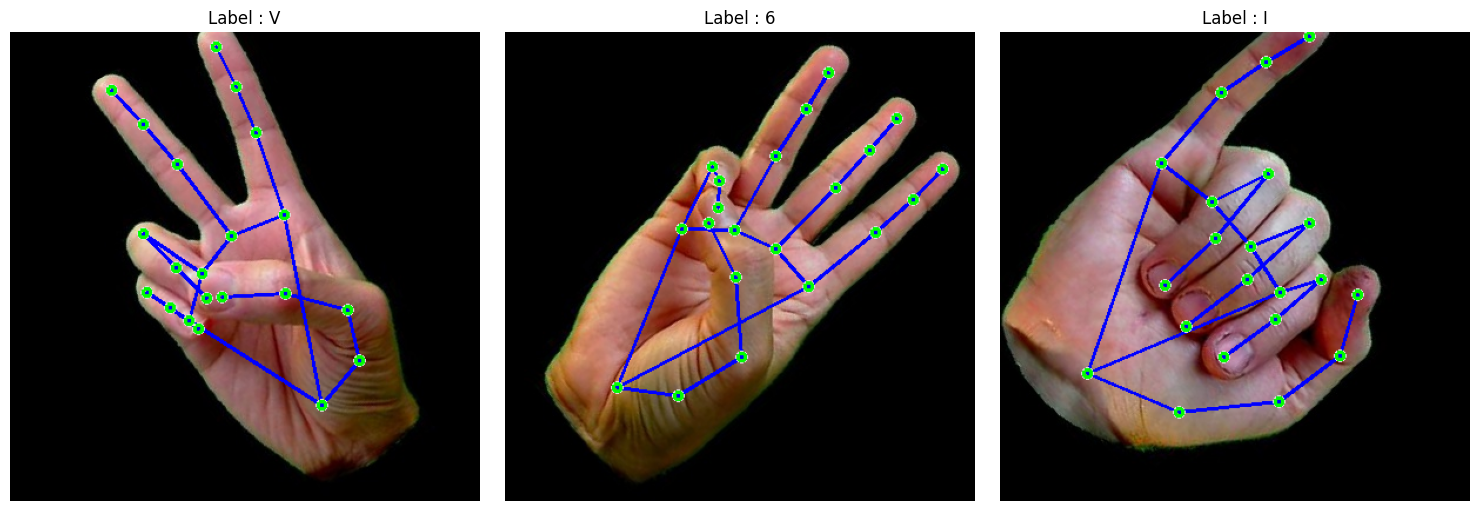

In [12]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import mediapipe as mp

# Initialisation de MediaPipe Hands et Drawing utils
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

# Fonction pour détecter et annoter les landmarks
def detect_hands_with_landmarks(image):
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir l'image en RGB pour MediaPipe
    results = hands.process(img_rgb)  # Détecter les landmarks
    
    # Si des landmarks sont détectés, les dessiner sur l'image
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                image, 
                hand_landmarks, 
                mp_hands.HAND_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=3),  # Landmarks
                mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2, circle_radius=3),  # Connexions
            )
    return image

# Charger les annotations depuis le fichier CSV
annotations_df = pd.read_csv('annotations.csv')

# Sélectionner 3 images aléatoirement
selected_indices = np.random.choice(annotations_df.index, 3, replace=False)
selected_images = annotations_df.iloc[selected_indices]

# Appliquer la détection et afficher les images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Grille 1x3 pour 3 images
axes = axes.ravel()

for i, (index, row) in enumerate(selected_images.iterrows()):
    img_path = os.path.join(DATA_PATH, row['label'], row['filename'])  # Chemin complet de l'image
    image = cv2.imread(img_path)  # Charger l'image
    if image is not None:
        annotated_image = detect_hands_with_landmarks(image)  # Annoter avec les landmarks
        annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)  # Convertir en RGB pour Matplotlib
        axes[i].imshow(annotated_image)
        axes[i].set_title(f"Label : {row['label']}")  # Ajouter le label comme titre
        axes[i].axis('off')

plt.tight_layout()
plt.show()


### Preprocess the images by converting them to grayscale and resizing them.

In [ ]:
X = []
y = []

for index, row in annotations_df.iterrows():
    img_path = os.path.join(DATA_PATH, row['label'], row['filename'])
    img = cv2.imread(img_path)
    img = detect_hands(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (50, 50))
    X.append(img)
    y.append(row['label'])

X = np.array(X).astype('float32') / 255.0
label_to_index = {label: index for index, label in enumerate(sorted(set(y)))}
y_indices = np.array([label_to_index[label] for label in y])
y_categorical = to_categorical(y_indices, num_classes=len(label_to_index))

X_train, X_temp, y_train, y_temp = train_test_split(X, y_categorical, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

/Users/salaheddine/PycharmProjects/Sign_laguage_project/venv/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


### Save the processed data for model training.

In [8]:
np.savez('preprocessed_data.npz', X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test)
print("Data saved for model training.")

Data saved for model training.
